In [1]:
# load python packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib
import math
import pprint

# load dataset
import scipy.io          
dataset = scipy.io.loadmat('dataset.mat')

# get training and testing sets
x_train = dataset['train_image']
x_test = dataset['test_image']
y_train = dataset['train_label']
y_test = dataset['test_label']

nmb_samples, img_rows, img_cols = x_train.shape[0], x_train.shape[1], x_train.shape[2]
nmb_test_samples = x_test.shape[0]

# adjust training image format
import tensorflow as tf
from keras import backend as K

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# type casting and dimensionality transformations
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
    
pp = pprint.PrettyPrinter(indent=4)

Using TensorFlow backend.


In [2]:
# HU MOMENTS. Unique value of the image
# close between similar images

def momgeom(I, X, Y, p, q):
    mpq = sum(sum(I*(X**p)*(Y**q)))
    return mpq
    
def hu_moments(img):
    N, M = img.shape
    X, Y = np.mgrid[0:M,0:N]
    m00 = momgeom(img, X, Y, 0, 0)
    m10 = momgeom(img, X, Y, 1, 0)
    m01 = momgeom(img, X, Y, 0, 1)
    m20 = momgeom(img, X, Y, 2, 0)
    m02 = momgeom(img, X, Y, 0, 2)
    m11 = momgeom(img, X, Y, 1, 1)
    
    div20 = ((m10**2) / m00)
    div02 = ((m01**2) / m00)
    mult11 =((m10*m01) / m00)
    div = m00**2
    
    n20 = (m20-div20)/div
    n02 = (m02-div02)/div
    n11 = (m11-mult11)/div
   
    mom1 = n20+n02
    mom2 = ((n20-n02)**2) + 4*n11**2
    
    hu = [mom1,mom2]
    return hu

def hu_points(train_sample):
    hupoints = []
    for i in range (200):
        first_image = train_sample[i,:,:,0]
        first_image = np.array(first_image, dtype='float')
        img = first_image.reshape((img_rows, img_cols))
        hupoints.append(hu_moments(img))
    hupoints = np.array(hupoints, dtype='float')
    hupoints = hupoints.reshape((200, 2))
    return hupoints

# POINTS with 2 hu moments that are going to be the coordinates for the kdtree

def coord_points(x_array, y_array):
    points = []
    for i in range(200):
        IP = x_array[i, 0]
        IL = y_array[i, 0]
        points.append([IP, IL])
    
    points = np.array(points, dtype='float')
    points = points.reshape((200, 2))
    return points

# KDTREE KNN

def EUdistance(points1, points2):
    x1, y1 = points1
    x2, y2 = points2    
    dx = x1 - x2
    dy = y1 - y2
    dist = math.sqrt((dx*dx)+(dy*dy))
    
    return dist

def buildkdtree(points, depth = 0):
    n = len(points)
    if n <= 0:
        return None
    axis = depth % 2
    sorted_points = sorted(points, key=lambda point: point[axis])
    return {
        'point' : sorted_points[n // 2],
        'left' : buildkdtree(sorted_points[:n // 2], depth+1),
        'right' : buildkdtree(sorted_points[n // 2+1:], depth+1)
    }

def kdtree_closestpoint(root, point, depth=0, best=None):
    if root is None:
        return best
    axis = depth % 2
    next_best = None
    next_branch = None
    if best is None or EUdistance(point, best) > EUdistance(point, root['point']):
        next_best = root['point']
    else:
        next_best = best
    if point[axis] < root['point'][axis]:
        next_branch = root['left']
    else:
        next_branch = root['right']
    return kdtree_closestpoint(next_branch, point, depth + 1, next_best)

def kNearestNeighbor(tree_root, test_array):
    prediction = []
    for i in range(200):
        best_point = kdtree_closestpoint(tree_root, test_array[i][:])
        prediction.append(best_point)
    return prediction

In [3]:
# KDTREE KNN MODEL

xtrain_husample = hu_points(x_train)
xtest_husample = hu_points(x_test)
train_points = coord_points (xtrain_husample, y_train)
test_points = coord_points (xtest_husample, y_test)
kdtree = buildkdtree(train_points)
pp.pprint(kdtree)

{   'left': {   'left': {   'left': {   'left': {   'left': {   'left': {   'left': {   'left': None,
                                                                                        'point': array([ 0.22056321,  0.        ]),
                                                                                        'right': None},
                                                                            'point': array([ 0.22119988,  0.        ]),
                                                                            'right': {   'left': None,
                                                                                         'point': array([ 0.22528197,  0.        ]),
                                                                                         'right': None}},
                                                                'point': array([ 0.22546298,  0.        ]),
                                                                'right': {   'left': {   'le

                                         'right': {   'left': {   'left': {   'left': {   'left': None,
                                                                                          'point': array([ 0.23408816,  1.        ]),
                                                                                          'right': None},
                                                                              'point': array([ 0.23457983,  1.        ]),
                                                                              'right': None},
                                                                  'point': array([ 0.23543564,  1.        ]),
                                                                  'right': {   'left': {   'left': None,
                                                                                           'point': array([ 0.23656319,  1.        ]),
                                                                                          

                                                                   'right': {   'left': {   'left': None,
                                                                                            'point': array([ 0.28086677,  1.        ]),
                                                                                            'right': None},
                                                                                'point': array([ 0.28436999,  0.        ]),
                                                                                'right': None}}}},
                             'point': array([ 0.2882949,  0.       ]),
                             'right': {   'left': {   'left': {   'left': {   'left': {   'left': None,
                                                                                          'point': array([ 0.28868777,  0.        ]),
                                                                                          'right': None},
            

                                                                                'point': array([ 0.34747871,  1.        ]),
                                                                                'right': None}},
                                                       'point': array([ 0.35179981,  1.        ]),
                                                       'right': {   'left': {   'left': {   'left': None,
                                                                                            'point': array([ 0.35195219,  1.        ]),
                                                                                            'right': None},
                                                                                'point': array([ 0.35197692,  1.        ]),
                                                                                'right': None},
                                                                    'point': array([ 0.35316964,  1.        ])

In [4]:
predict = kNearestNeighbor(kdtree, test_points)
predict = np.array(predict)
predict = np.sort(predict, axis=0)
predict

array([[ 0.23328751,  0.        ],
       [ 0.23328751,  0.        ],
       [ 0.23328751,  0.        ],
       [ 0.23328751,  0.        ],
       [ 0.23328751,  0.        ],
       [ 0.23328751,  0.        ],
       [ 0.23328751,  0.        ],
       [ 0.23543564,  0.        ],
       [ 0.23543564,  0.        ],
       [ 0.23877675,  0.        ],
       [ 0.23919259,  0.        ],
       [ 0.23919259,  0.        ],
       [ 0.23919259,  0.        ],
       [ 0.23919259,  0.        ],
       [ 0.2419954 ,  0.        ],
       [ 0.2423529 ,  0.        ],
       [ 0.2423529 ,  0.        ],
       [ 0.2423529 ,  0.        ],
       [ 0.2444634 ,  0.        ],
       [ 0.2444634 ,  0.        ],
       [ 0.2446394 ,  0.        ],
       [ 0.24991959,  0.        ],
       [ 0.24991959,  0.        ],
       [ 0.24991959,  0.        ],
       [ 0.24991959,  0.        ],
       [ 0.24991959,  0.        ],
       [ 0.24991959,  0.        ],
       [ 0.24991959,  0.        ],
       [ 0.2527254 ,

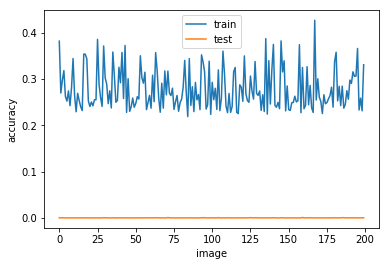

In [5]:
# KDTREE KNN MODEL

plt.plot(xtest_husample)
plt.ylabel('accuracy')
plt.xlabel('image')
plt.legend(['train', 'test'], )
plt.show()

In [6]:
# DECISION TREE

# POINTS with 2 hu moments that are going to be the splits conditions

def coord_points(x_array, y_array):
    points = []
    for i in range(200):
        IP1 = x_array[i, 0]
        IP2 = x_array[i, 1]
        IL = y_array[i, 0]
        points.append([IP1, IP2, IL])
    
    points = np.array(points, dtype='float')
    points = points.reshape((200, 3))
    return points

def split(node, max_depth, min_size, depth):
    left, right = node['classes']
    del(node['classes'])
    if not left or not right:
        node['left'] = node['right'] = terminal(left + right)
        return
    if depth >= max_depth:
        node['left'], node['right'] = terminal(left), terminal(right)
        return
    if len(left) <= min_size:
        node['left'] = terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    if len(right) <= min_size:
        node['right'] = terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

def terminal(classes):
    outcomes = [point[-1] for point in classes]
    return max(set(outcomes), key=outcomes.count)

def test_split(index, value, x_array):
    left, right = list(), list()
    for point in x_array:
        if point[index] < value:
            left.append(point)
        else:
            right.append(point)
    return left, right

def get_split(x_array):
    class_values = list(set(point[-1] for point in x_array))
    b_index, b_value, b_classes = 999, 999, None
    for index in range(len(x_array[0])-1):
        for point in x_array:
            classes = test_split(index, point[index], x_array)
            b_index, b_value, b_classes = index, point[index], classes
    return {'index':b_index, 'value':b_value, 'classes':b_classes}

def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

In [7]:
def predict(node, point):
    if point[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], point)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], point)
        else:
            return node['right']

def decisiontree(train, test, max_depth, min_size):
    tree = build_tree(train, max_depth, min_size)
    predictions = list()
    for point in test:
        prediction = predict(tree, point)
        predictions.append(prediction)
    return(predictions)

train_points = coord_points (xtrain_husample, y_train)
test_points = coord_points (xtest_husample, y_test)
sumhu1 = sum(xtrain_husample[:][0])
sumhu2 = sum(xtrain_husample[:][1])

tree = build_tree(train_points, 3, 0.00001)
pp.pprint(tree)

{   'index': 1,
    'left': {   'index': 1,
                'left': {   'index': 1,
                            'left': 0.0,
                            'right': 0.0,
                            'value': 4.4270733697131871e-06},
                'right': {   'index': 1,
                             'left': 1.0,
                             'right': 1.0,
                             'value': 1.6761874997685416e-05},
                'value': 1.6761874997685416e-05},
    'right': {   'index': 1,
                 'left': 1.0,
                 'right': 1.0,
                 'value': 3.1544479694121049e-05},
    'value': 3.1544479694121049e-05}


In [8]:
dstree = decisiontree(train_points, test_points, 3, 0.00001)
print(dstree)

[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

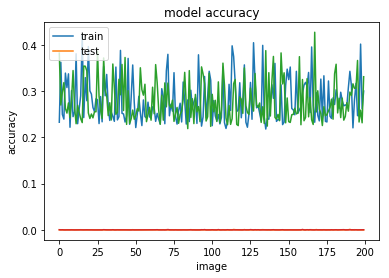

In [9]:
# DECISION TREE MODEL PLOT

# summarize for accuracy
plt.plot(xtrain_husample)
plt.plot(xtest_husample)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('image')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
# load python packages
import scipy as sp
import pandas as pd
import IPython
import sklearn
import keras

# import keras packages
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D 

batch_size = 32
num_classes = 2
epochs = 200

y_train = keras.utils.to_categorical(np.squeeze(y_train), num_classes)
y_test = keras.utils.to_categorical(np.squeeze(y_test), num_classes)

print (x_train)
print (y_train)
print (y_test)




[[[[ 0.31869477]
   [ 0.26470309]
   [ 0.21069679]
   ..., 
   [ 0.73730606]
   [ 0.60689646]
   [ 0.83849382]]

  [[ 0.27841038]
   [ 0.35074994]
   [ 0.29601583]
   ..., 
   [ 0.72570229]
   [ 0.79638261]
   [ 0.76662123]]

  [[ 0.21685648]
   [ 0.34094632]
   [ 0.11451978]
   ..., 
   [ 0.85599673]
   [ 0.67184711]
   [ 0.7035135 ]]

  ..., 
  [[ 0.13055801]
   [ 0.27388459]
   [ 0.4922944 ]
   ..., 
   [ 0.83069903]
   [ 0.75323951]
   [ 0.71195644]]

  [[ 0.19890541]
   [ 0.24928831]
   [ 0.40299186]
   ..., 
   [ 0.17380092]
   [ 0.36220497]
   [ 0.15890989]]

  [[ 0.24754825]
   [ 0.34144107]
   [ 0.        ]
   ..., 
   [ 0.27986345]
   [ 0.15280698]
   [ 0.22390652]]]


 [[[ 0.19910152]
   [ 0.37254351]
   [ 0.17724997]
   ..., 
   [ 0.22551104]
   [ 0.46162289]
   [ 0.34233537]]

  [[ 0.4824138 ]
   [ 0.47066453]
   [ 0.41481256]
   ..., 
   [ 0.35099083]
   [ 0.23763171]
   [ 0.20022872]]

  [[ 0.35446131]
   [ 0.49847481]
   [ 0.38347328]
   ..., 
   [ 0.26170713]
   [ 0.20

In [11]:
# CNN model (2 hidden layers with 512 nodes)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu', 
                 input_shape=input_shape))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# compile model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# training
history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))

Train on 200 samples, validate on 200 samples
Epoch 1/200
200/200 [==============================] - 2s 12ms/step - loss: 0.8663 - acc: 0.4350 - val_loss: 0.7009 - val_acc: 0.5000
Epoch 2/200
200/200 [==============================] - 1s 7ms/step - loss: 0.6931 - acc: 0.4950 - val_loss: 0.6989 - val_acc: 0.5000
Epoch 3/200
200/200 [==============================] - 1s 7ms/step - loss: 0.6899 - acc: 0.5300 - val_loss: 0.7063 - val_acc: 0.5000
Epoch 4/200
200/200 [==============================] - 1s 6ms/step - loss: 0.6858 - acc: 0.5650 - val_loss: 0.6771 - val_acc: 0.6050
Epoch 5/200
200/200 [==============================] - 1s 6ms/step - loss: 0.6670 - acc: 0.6050 - val_loss: 0.6705 - val_acc: 0.6300
Epoch 6/200
200/200 [==============================] - 1s 7ms/step - loss: 0.6741 - acc: 0.5850 - val_loss: 0.6799 - val_acc: 0.5050
Epoch 7/200
200/200 [==============================] - 1s 6ms/step - loss: 0.6542 - acc: 0.6200 - val_loss: 0.6388 - val_acc: 0.6700
Epoch 8/200
200/200 [=

200/200 [==============================] - 1s 7ms/step - loss: 4.0352e-05 - acc: 1.0000 - val_loss: 0.1178 - val_acc: 0.9550
Epoch 121/200
200/200 [==============================] - 2s 8ms/step - loss: 3.9458e-05 - acc: 1.0000 - val_loss: 0.1194 - val_acc: 0.9550
Epoch 122/200
200/200 [==============================] - 1s 7ms/step - loss: 3.8796e-05 - acc: 1.0000 - val_loss: 0.1189 - val_acc: 0.9550
Epoch 123/200
200/200 [==============================] - 1s 7ms/step - loss: 3.8684e-05 - acc: 1.0000 - val_loss: 0.1171 - val_acc: 0.9550
Epoch 124/200
200/200 [==============================] - 1s 6ms/step - loss: 3.7641e-05 - acc: 1.0000 - val_loss: 0.1162 - val_acc: 0.9600
Epoch 125/200
200/200 [==============================] - 1s 6ms/step - loss: 3.7434e-05 - acc: 1.0000 - val_loss: 0.1183 - val_acc: 0.9550
Epoch 126/200
200/200 [==============================] - 1s 7ms/step - loss: 3.6532e-05 - acc: 1.0000 - val_loss: 0.1181 - val_acc: 0.9550
Epoch 127/200
200/200 [==================

200/200 [==============================] - 1s 6ms/step - loss: 1.9811e-05 - acc: 1.0000 - val_loss: 0.1207 - val_acc: 0.9550
Epoch 180/200
200/200 [==============================] - 1s 6ms/step - loss: 1.9586e-05 - acc: 1.0000 - val_loss: 0.1215 - val_acc: 0.9550
Epoch 181/200
200/200 [==============================] - 1s 6ms/step - loss: 1.9423e-05 - acc: 1.0000 - val_loss: 0.1213 - val_acc: 0.9550
Epoch 182/200
200/200 [==============================] - 1s 6ms/step - loss: 1.9230e-05 - acc: 1.0000 - val_loss: 0.1209 - val_acc: 0.9550
Epoch 183/200
200/200 [==============================] - 1s 6ms/step - loss: 1.9071e-05 - acc: 1.0000 - val_loss: 0.1216 - val_acc: 0.9550
Epoch 184/200
200/200 [==============================] - 1s 6ms/step - loss: 1.8928e-05 - acc: 1.0000 - val_loss: 0.1215 - val_acc: 0.9550
Epoch 185/200
200/200 [==============================] - 1s 6ms/step - loss: 1.8712e-05 - acc: 1.0000 - val_loss: 0.1214 - val_acc: 0.9550
Epoch 186/200
200/200 [==================

Train loss: 1.64834891621e-05
Train accuracy: 1.0
Test loss: 0.122092348561
Test accuracy: 0.955


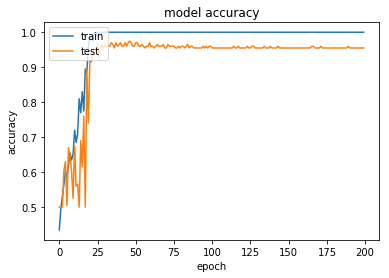

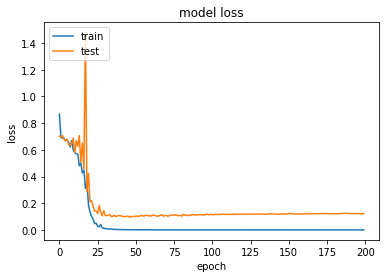

In [12]:
# print train and test losses and classification accuracies
score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()